In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import talib
%matplotlib inline
from scipy.stats import pearsonr, spearmanr

In [2]:
name = 'total'

In [3]:
df = pd.read_csv('../data/btcusdt_1h_'+name+'.csv')

In [4]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29808 entries, 0 to 29807
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  29808 non-null  object 
 1   open      29808 non-null  float64
 2   high      29808 non-null  float64
 3   low       29808 non-null  float64
 4   close     29808 non-null  float64
 5   volume    29808 non-null  float64
dtypes: float64(5), object(1)
memory usage: 1.4+ MB


In [5]:
df['close_vol'] = df['close'] * df['volume']

In [6]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29808 entries, 0 to 29807
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   datetime   29808 non-null  object 
 1   open       29808 non-null  float64
 2   high       29808 non-null  float64
 3   low        29808 non-null  float64
 4   close      29808 non-null  float64
 5   volume     29808 non-null  float64
 6   close_vol  29808 non-null  float64
dtypes: float64(6), object(1)
memory usage: 1.6+ MB


In [7]:
# Adding exp_RSI
df['RSI'] = talib.RSI(df['close'], timeperiod=24)
df['RSI'] -= 50
df['RSI'] = df['RSI'].apply(lambda x: x if x > 20 or x < -20 else 0)
df['RSI'] = df['RSI'].apply(lambda x: x - 20 if x >= 20 else x)
df['RSI'] = df['RSI'].apply(lambda x: x + 20 if x <= -20 else x)                          
df.dropna(inplace=True)
df['exp_RSI'] = 0
df['exp_RSI'] = np.exp(np.abs(df['RSI']))
df['exp_RSI'] = np.where(df['RSI'] > 0, -df['exp_RSI'], df['exp_RSI'])

In [8]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29808 entries, 0 to 29807
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   datetime   29808 non-null  object 
 1   open       29808 non-null  float64
 2   high       29808 non-null  float64
 3   low        29808 non-null  float64
 4   close      29808 non-null  float64
 5   volume     29808 non-null  float64
 6   close_vol  29808 non-null  float64
 7   RSI        29808 non-null  float64
 8   exp_RSI    29808 non-null  float64
dtypes: float64(8), object(1)
memory usage: 2.0+ MB


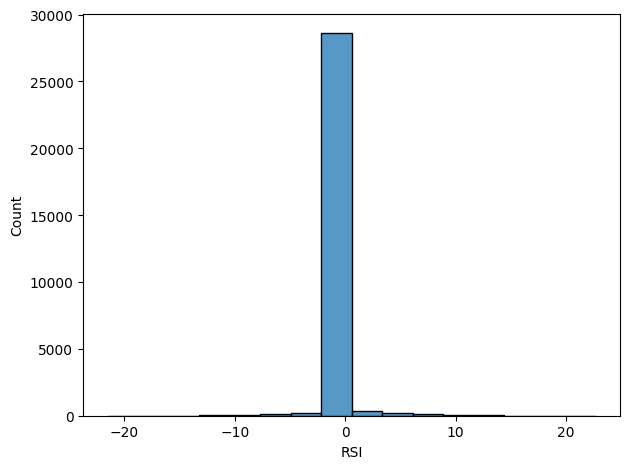

In [9]:
ax = sns.histplot(df.RSI.dropna())
plt.tight_layout()

In [10]:
high, mid, low = talib.BBANDS(df.close, timeperiod=48, nbdevup=2, nbdevdn=2, matype=0)
df['bb_high'] = high
df['bb_low'] = low
df['bb_high'] = df.bb_high.sub(df.close).div(df.bb_high).apply(np.log1p)
df['bb_low'] = df.close.sub(df.bb_low).div(df.close).apply(np.log1p)

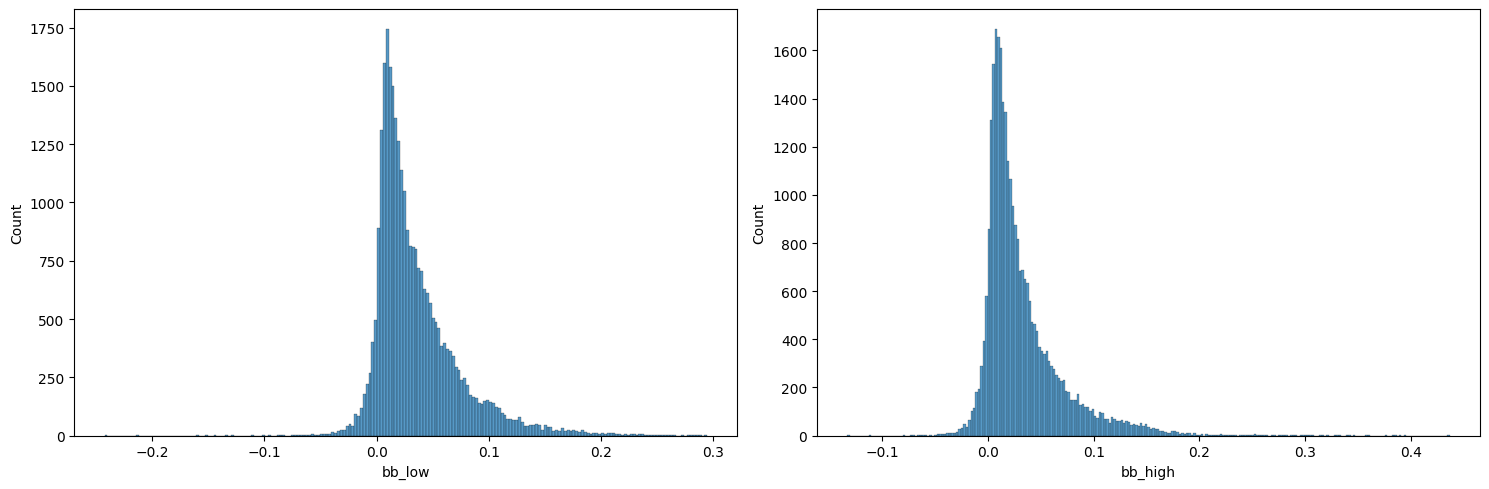

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(df['bb_low'].dropna(), ax=axes[0])
sns.histplot(df['bb_high'].dropna(), ax=axes[1])
plt.tight_layout()

In [12]:
df['atr'] = talib.ATR(df.high, df.low, df.close, timeperiod=24)

<Axes: xlabel='atr', ylabel='Count'>

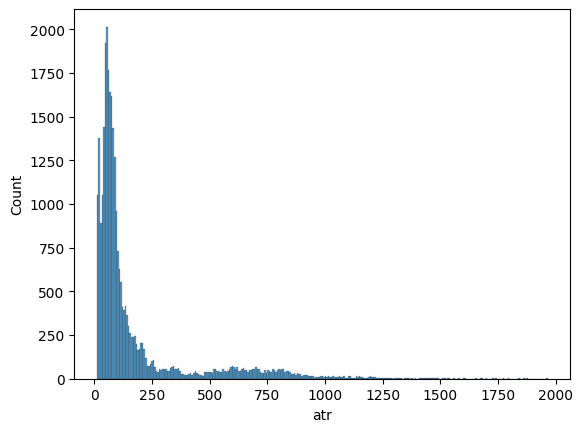

In [13]:
sns.histplot(df.atr.dropna())

In [14]:
df['macd'], df['signal'], _ = talib.MACD(df.close, fastperiod=24, slowperiod=48, signalperiod=12)
shifted_signal = df['signal'].shift(1)
shifted_signal.fillna(0, inplace=True)
df['macd'].fillna(0, inplace=True)
df['macd_signal'] = df['signal'] - shifted_signal

In [15]:
df.macd.describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999]).apply(lambda x: f'{x:,.1f}')


count    29,808.0
mean          8.9
std         243.1
min      -2,040.2
0.1%     -1,673.1
1%         -852.4
2%         -629.3
3%         -440.5
4%         -344.3
5%         -281.0
50%           4.6
95%         334.8
96%         397.7
97%         509.6
98%         653.2
99%         833.6
99.9%     1,335.8
max       1,957.0
Name: macd, dtype: object

<Axes: xlabel='macd', ylabel='Count'>

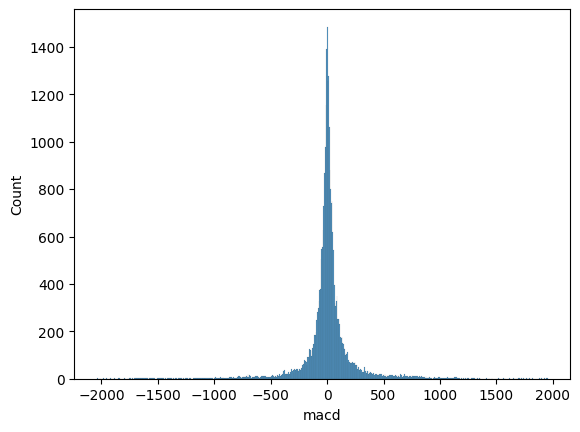

In [16]:
sns.histplot(df.macd.dropna())

<Axes: xlabel='OBV', ylabel='Count'>

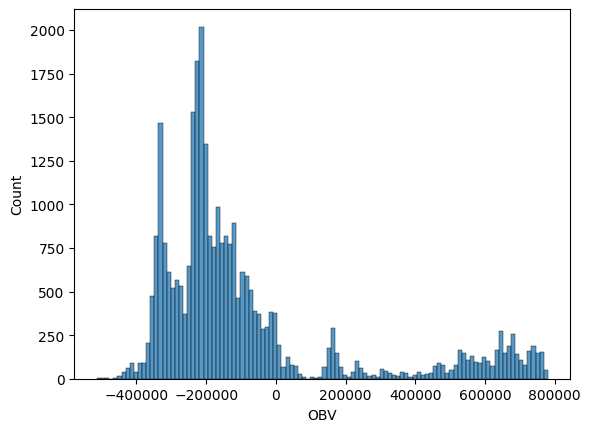

In [17]:
df['OBV'] = talib.OBV(df['close'], df['volume'])
sns.histplot(df.OBV.dropna())

<Axes: xlabel='EMA_Slope', ylabel='Count'>

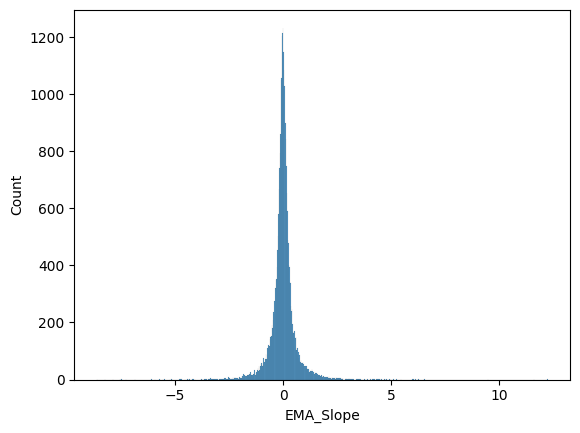

In [18]:
df['EMA'] = talib.EMA(df['close'], timeperiod=2)
df['EMA_Slope'] = -df['EMA'].pct_change(1)*100
sns.histplot(df.EMA_Slope.dropna())

In [19]:
df['vwap'] = talib.WMA(df['close_vol'], timeperiod=24) / talib.WMA(df['volume'], timeperiod=24)

In [20]:
lags = [1,4,12,24,48,168]

In [21]:
returns = df.close.pct_change()
percentiles=[.0001, .001, .01]
percentiles+= [1-p for p in percentiles]
returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles').style.format(lambda x: f'{x:,.2%}')

,percentiles
std,0.89%
min,-18.21%
0.01%,-9.12%
0.1%,-5.86%
1%,-2.66%
50%,0.01%
99%,2.60%
99.9%,6.02%
99.99%,11.51%
max,17.38%


In [22]:
q = 0.0001

In [23]:
for lag in lags:
    df[f'return_{lag}d'] = (df.close
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(q),upper=x.quantile(1 - q)))
                                .add(1)
                                .pow(1 / lag)
                                .sub(1)
                                )*1000

In [24]:
for t in [1, 2, 3, 4, 5]:
    for lag in [1, 4, 12, 24]:
        df[f'return_{lag}d_lag{t}'] = (df[f'return_{lag}d'].shift(t * lag))

In [25]:
for t in [1, 4, 12, 24]:
    df[f'target_{t}d'] = df[f'return_{t}d'].shift(-t)

In [26]:
df.dropna(inplace=True)

In [27]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29616 entries, 168 to 29783
Data columns (total 49 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   datetime         29616 non-null  object 
 1   open             29616 non-null  float64
 2   high             29616 non-null  float64
 3   low              29616 non-null  float64
 4   close            29616 non-null  float64
 5   volume           29616 non-null  float64
 6   close_vol        29616 non-null  float64
 7   RSI              29616 non-null  float64
 8   exp_RSI          29616 non-null  float64
 9   bb_high          29616 non-null  float64
 10  bb_low           29616 non-null  float64
 11  atr              29616 non-null  float64
 12  macd             29616 non-null  float64
 13  signal           29616 non-null  float64
 14  macd_signal      29616 non-null  float64
 15  OBV              29616 non-null  float64
 16  EMA              29616 non-null  float64
 17  EMA_Slope 

In [28]:
df.to_csv('data/btc_1h_'+name+'.csv', index=False)

1.68% (0.39%)


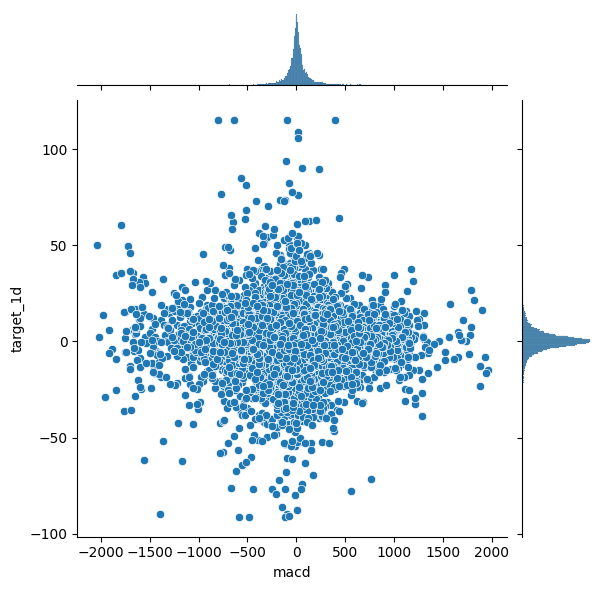

In [29]:
metric = 'macd'
target = 'target_1d'
j=sns.jointplot(x=metric, y=target, data=df)
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')
